<a href="https://colab.research.google.com/github/genaiconference/AgenticAI_GenAIHack/blob/main/02_LangGraph_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contents

* Node
* Edge
* Stream
* Build Simple Graph using LangGraph
* Example: Sentiment Analysis
* State
* Conditional Edge
* Branching
* Example: Ad Competition and Screen play writing


In [69]:
# @title
# prompt: How to wrap text on collab notebook output

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [70]:
# @title
# prompt: How to expand the hight of colab notebook output

from google.colab.output import eval_js
eval_js('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})')


In [71]:
!git clone https://github.com/genaiconference/AgenticAI_GenAIHack.git

fatal: destination path 'AgenticAI_GenAIHack' already exists and is not an empty directory.


In [72]:
!pip install -r /content/AgenticAI_GenAIHack/requirements_agenti_ai.txt

In [73]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path="/content/.env")

GPT4o_DEPLOYMENT_NAME = os.getenv('GPT4o_DEPLOYMENT_NAME')
API_KEY = os.getenv('east_us2_API_KEY')
API_BASE = os.getenv('east_us2_API_BASE')
API_TYPE = os.getenv('API_TYPE')
API_VERSION = os.getenv('API_VERSION')

from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
        azure_endpoint=API_BASE,
        openai_api_version=API_VERSION,
        azure_deployment=GPT4o_DEPLOYMENT_NAME,
        openai_api_key=API_KEY,
        openai_api_type=API_TYPE,
        temperature=0)

In [74]:
# Add open ai style

#Simple LangGraph
2 Nodes connected by an edge

In [75]:
llm.invoke("Tell me an ant joke")

AIMessage(content="Sure, here's a classic ant joke for you:\n\nWhy don't ants get sick?\n\nBecause they have tiny ant-bodies!", response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 12, 'total_tokens': 36}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_abc28019ad', 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {}}, id='run-49fc0bb0-474b-4214-aad1-66b62df23b56-0')

Now let's make each Node is a **function**

In [76]:
def func_1(input_1):
    return input_1 + " First Function"

def func_2(input_2):
    return input_2 + " to Second Function"

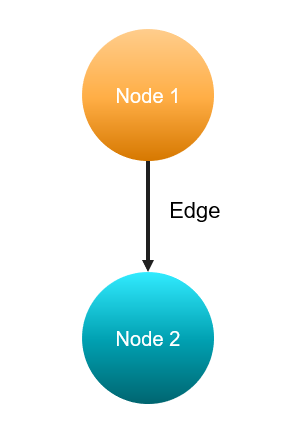

In [77]:
from langgraph.graph import Graph

# Define a graph
workflow = Graph()

# Add nodes to the graph
workflow.add_node("node_1",func_1)
workflow.add_node("node_2",func_2)

# Time to add edge
workflow.add_edge("node_1", "node_2")

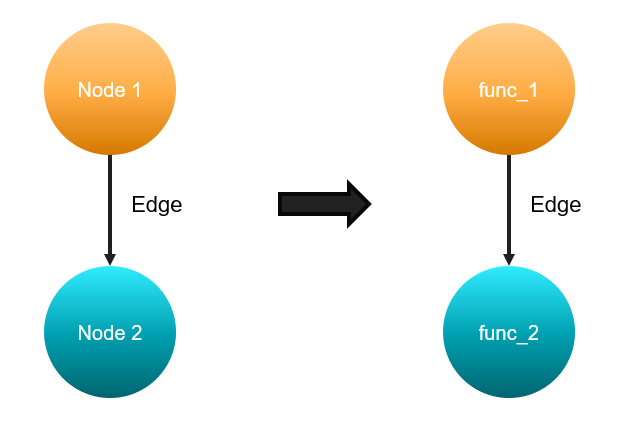

In [78]:
#Set Entry and Exit points
workflow.set_entry_point("node_1")
workflow.set_finish_point("node_2")

app = workflow.compile()

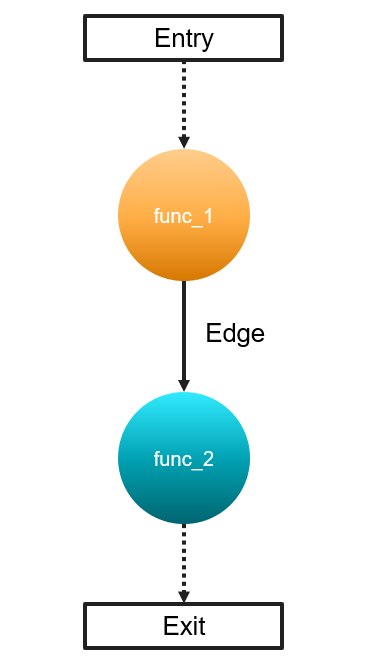

In [79]:
app.invoke("I move from")

'I move from First Function to Second Function'

**Streaming output from LangGraph**

stream() method outputs dictionary of the format

```
{node_name : output_from_the_node}
```



In [80]:
graph_input = 'I am moving from'
for output in app.stream(graph_input):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("---\n")

Output from node 'node_1':
---
I am moving from First Function
---

Output from node 'node_2':
---
I am moving from First Function to Second Function
---



# Sentiment Analysis using LangGraph

In [81]:
def sentiment_analysis(input_1):
    SA_prompt = f"""You are an expert at performing sentiment analysis.
    Your task is identify the sentiment of the provided input.
    Provide only the sentiment based on the user input.
    Don't include reasoning.

    User input: {input_1}"""

    response = llm.invoke(SA_prompt)
    return response.content

def convert_to_upper(input_2):
    Sentiment_UPPER = input_2.upper()
    response = f"Here is the SENTIMENT in UPPER case: {Sentiment_UPPER}"
    return response

In [82]:
# Define a Langchain graph
workflow = Graph()

workflow.add_node("sentiment_analysis", sentiment_analysis)
workflow.add_node("convert_to_upper", convert_to_upper)

workflow.add_edge('sentiment_analysis', 'convert_to_upper')

workflow.set_entry_point("sentiment_analysis")
workflow.set_finish_point("convert_to_upper")

app = workflow.compile()

### Visulize the Graph

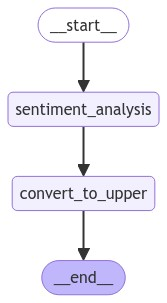

In [83]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [84]:
tweet = "The movie was so nice that I walked out in 2 min"
app.invoke(tweet)

'Here is the SENTIMENT in UPPER case: NEGATIVE'

In [85]:
tweet = "Wish the movie was nice. But it was extraordinary"
app.invoke(tweet)

'Here is the SENTIMENT in UPPER case: POSITIVE'

### Streaming

In [86]:
for output in app.stream(tweet):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("---\n")

Output from node 'sentiment_analysis':
---
Positive
---

Output from node 'convert_to_upper':
---
Here is the SENTIMENT in UPPER case: POSITIVE
---



# State

Now Let's introduce the state to the Graph.

One of the central concepts of LangGraph is state. Each graph execution creates a state that is passed between nodes in the graph as they execute, and each node updates this internal state with its return value after it executes.


## Benefits

-Enables stateful applications that can maintain context over multiple interactions

-Allows for coordination between multiple agents or components

-Facilitates error handling and recovery via checkpointing

-Simplifies the development of complex workflows

In [87]:
import torch
from transformers import pipeline

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    user_review: str
    sentiment_label: str
    sentiment_label_in_upper: str


def sentiment_analysis(state):
    print("------ENTERING: SENTIMENT ANALYSIS NODE------")
    print(state)
    SA_prompt = f"""You are an expert at performing sentiment analysis.
    Your task is identify the sentiment of the provided input.
    Provide only the sentiment based on the user input.
    Don't include reasoning.

    User input: {state['user_review']}"""

    response = llm.invoke(SA_prompt)

    return {"sentiment_label": response.content}


def convert_to_upper(state):
    print("------ENTERING: CONVERT_TO_UPPER NODE------")
    print(state)
    Sentiment_UPPER = state['sentiment_label'].upper()
    return {"sentiment_label_in_upper": Sentiment_UPPER}



# Define a graph
workflow = StateGraph(State)

workflow.add_node("sentiment_analysis", sentiment_analysis)
workflow.add_node("convert_to_upper", convert_to_upper)

workflow.add_edge('sentiment_analysis', 'convert_to_upper')

workflow.set_entry_point("sentiment_analysis")
workflow.set_finish_point("convert_to_upper")

app = workflow.compile()

### Visualize the Graph

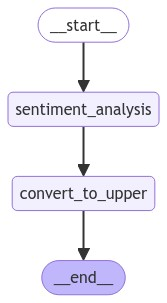

In [88]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [89]:
from simple_colors import *

review = "The movie was so nice that I walked out in 2 min"
input_review = {"user_review": review}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for output in app.stream(input_review, thread, stream_mode="values"):
    print(cyan(output, ['bold']))

{'user_review': 'The movie was so nice that I walked out in 2 min'}
------ENTERING: SENTIMENT ANALYSIS NODE------
{'user_review': 'The movie was so nice that I walked out in 2 min', 'sentiment_label': None, 'sentiment_label_in_upper': None}
{'user_review': 'The movie was so nice that I walked out in 2 min', 'sentiment_label': 'Negative'}
------ENTERING: CONVERT_TO_UPPER NODE------
{'user_review': 'The movie was so nice that I walked out in 2 min', 'sentiment_label': 'Negative', 'sentiment_label_in_upper': None}
{'user_review': 'The movie was so nice that I walked out in 2 min', 'sentiment_label': 'Negative', 'sentiment_label_in_upper': 'NEGATIVE'}


In [90]:
from simple_colors import *

review = "Wish the movie was nice. But it was extraordinary"
input_review = {"user_review": review}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for output in app.stream(input_review, thread, stream_mode="values"):
    print(cyan(output, ['bold']))

{'user_review': 'Wish the movie was nice. But it was extraordinary'}
------ENTERING: SENTIMENT ANALYSIS NODE------
{'user_review': 'Wish the movie was nice. But it was extraordinary', 'sentiment_label': None, 'sentiment_label_in_upper': None}
{'user_review': 'Wish the movie was nice. But it was extraordinary', 'sentiment_label': 'Positive'}
------ENTERING: CONVERT_TO_UPPER NODE------
{'user_review': 'Wish the movie was nice. But it was extraordinary', 'sentiment_label': 'Positive', 'sentiment_label_in_upper': None}
{'user_review': 'Wish the movie was nice. But it was extraordinary', 'sentiment_label': 'Positive', 'sentiment_label_in_upper': 'POSITIVE'}


In [91]:
# Brandan -> Read write operator from the tutorial

## Conditional Edge

In [92]:
import functools, operator
from typing import Annotated
from IPython.display import Markdown
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    user_review: str
    sentiment_label: str
    feedback_analysis: str
    overall_status: Annotated[str, operator.add]


def sentiment_analysis(state):
    print("------ENTERING: SENTIMENT ANALYSIS NODE------")
    print(state)
    SA_prompt = f"""You are an expert at performing sentiment analysis.
    Your task is identify the sentiment of the provided input.
    Provide only the sentiment based on the user input.
    Don't include reasoning.

    User input: {state['user_review']}"""

    response = llm.invoke(SA_prompt)

    print("--------")
    print(red(f"Sentiment Identified: [{response.content}]", ['bold']))
    print("--------")

    return {"sentiment_label": response.content}



def user_review_analysis(state):
    print("------ENTERING: USER REVIEW ANALYSIS NODE------")
    print(state)
    feedback_analysis_prompt = f"""You are an expert at performing analysis on the user review. The review can be about a movie or a product.
    Your task is to carefully analyze the user review and give top reasons of what did not work for the user.
    Make the answer readable.
    Note: Provide your analysis only using the user review and justify the sentiment

    User review: {state['user_review']}
    Sentiment Identified: {state['sentiment_label']}"""

    response = llm.invoke(feedback_analysis_prompt)

    display(Markdown(response.content))

    return {"feedback_analysis": response.content}


# Define a graph
workflow = StateGraph(State)

workflow.add_node("sentiment_analysis", sentiment_analysis)
workflow.add_node("user_review_analysis", user_review_analysis)

workflow.set_entry_point("sentiment_analysis")

def where_to_go(state):
    if state["sentiment_label"].lower() == "positive":
        return END
    else:
        return "user_review_analysis"

workflow.add_conditional_edges("sentiment_analysis", where_to_go, ["user_review_analysis", END])

workflow.add_edge('user_review_analysis', END)

app = workflow.compile()

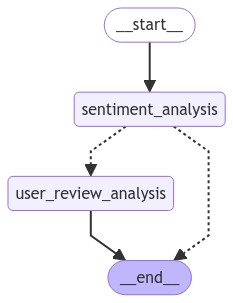

In [93]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [94]:
from simple_colors import *

review = """The movie was nice that I walked out of the hall in 1 min. Then came back within 5 min and then slept off. Woke up and saw back 2 back shows. enjoyed with pain"""

user_input = {"user_review": review}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for output in app.stream(user_input, thread, stream_mode="values"):
    print(cyan(output, ['bold']))

{'user_review': 'The movie was nice that I walked out of the hall in 1 min. Then came back within 5 min and then slept off. Woke up and saw back 2 back shows. enjoyed with pain', 'overall_status': ''}
------ENTERING: SENTIMENT ANALYSIS NODE------
{'user_review': 'The movie was nice that I walked out of the hall in 1 min. Then came back within 5 min and then slept off. Woke up and saw back 2 back shows. enjoyed with pain', 'sentiment_label': None, 'feedback_analysis': None, 'overall_status': ''}
--------
Sentiment Identified: [Mixed]
--------
{'user_review': 'The movie was nice that I walked out of the hall in 1 min. Then came back within 5 min and then slept off. Woke up and saw back 2 back shows. enjoyed with pain', 'sentiment_label': 'Mixed', 'overall_status': ''}
------ENTERING: USER REVIEW ANALYSIS NODE------
{'user_review': 'The movie was nice that I walked out of the hall in 1 min. Then came back within 5 min and then slept off. Woke up and saw back 2 back shows. enjoyed with pai

Based on the user review, here are the top reasons that did not work for the user:

1. **Initial Disinterest**:
   - The user mentioned walking out of the hall within 1 minute of the movie starting. This indicates that the beginning of the movie failed to capture their interest or attention.

2. **Inconsistent Engagement**:
   - The user returned to the hall within 5 minutes, suggesting a brief moment of reconsideration. However, this inconsistency in engagement shows that the movie did not maintain a compelling narrative or elements to keep the user consistently interested.

3. **Lack of Engagement Leading to Sleep**:
   - The user fell asleep during the movie. This is a strong indicator that the movie was not engaging or stimulating enough to keep the user awake and interested.

4. **Conflicting Emotions**:
   - The user mentioned "enjoyed with pain," which suggests a mixed sentiment. While there were moments of enjoyment, they were overshadowed by an overall sense of discomfort or dissatisfaction.

In summary, the movie failed to maintain the user's interest from the start, leading to disengagement and even sleep. The conflicting emotions of enjoyment and pain further highlight the mixed sentiment, indicating that while there were some positive aspects, they were not enough to overcome the negative experience.

{'user_review': 'The movie was nice that I walked out of the hall in 1 min. Then came back within 5 min and then slept off. Woke up and saw back 2 back shows. enjoyed with pain', 'sentiment_label': 'Mixed', 'feedback_analysis': 'Based on the user review, here are the top reasons that did not work for the user:\n\n1. **Initial Disinterest**:\n   - The user mentioned walking out of the hall within 1 minute of the movie starting. This indicates that the beginning of the movie failed to capture their interest or attention.\n\n2. **Inconsistent Engagement**:\n   - The user returned to the hall within 5 minutes, suggesting a brief moment of reconsideration. However, this inconsistency in engagement shows that the movie did not maintain a compelling narrative or elements to keep the user consistently interested.\n\n3. **Lack of Engagement Leading to Sleep**:\n   - The user fell asleep during the movie. This is a strong indicator that the movie was not engaging or stimulating enough to keep th

In [ ]:
from simple_colors import *

review = """Buckle up for a roller-coaster ride through cinematic chaos! The story idea is an absolute gem, brimming with potential, and the characters are nothing short of a casting director's dream-each one brimming with pizzazz and personality. But alas, their development seems to have been left in the microwave a bit too long, coming out half-baked.

The screenplay? It's flatter than a week-old soda. Though, I must admit, it does have its fizz in a few key moments, like the interval and the climax.

Dialogues? Let's just say they won't be winning any literary awards.

Now, onto the comedy-it's the kind that instead of tickling your funny bone, it goes straight for the jugular, and not in a good way. The world-building feels like it was put together with duct tape and imagination, lacking the immersive magic we hoped for.

But let's talk about the legendary Amitabh Bachchan, who is stellar as always.

Prabhas gives it his all, bless his heart.

Kamal Hassan makes a brief yet dazzling appearance, hinting at more brilliance in the next instalment.

Saswata Chatterjee? He brings his A-game, no doubt about it.

Deepika Padukone looks fine and delivers a decent performance, and her Telugu dubbing is better than that in the trailer.

Disha Patani is scorching enough to set the screen on fire in her limited screen time.

The rest of the cast, including Pashupati, Shobhana and Rajendra Prasad put in decent efforts. However, the film is sprinkled with cameos like confetti at a surprise party-most of which are more of a head-scratcher than a treat.

The action scenes? They're as disappointing as a soggy French fry.

Cinematography is serviceable, background music hits the right notes, but the songs miss the mark.

Production values are respectable, but direction sails somewhere in the middling seas of mediocrity.

Some VFX are eye-poppingly good, though.

Overall, it's a mixed bag of delights and letdowns-a cinematic hotpot where the ingredients are only half-cooked. Enjoy it for what it is, but don't be surprised if you leave the theater feeling a little unsatisfied"""

user_input = {"user_review": review}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for output in app.stream(user_input, thread, stream_mode="values"):
    print(cyan(output, ['bold']))

{'user_review': "Buckle up for a roller-coaster ride through cinematic chaos! The story idea is an absolute gem, brimming with potential, and the characters are nothing short of a casting director's dream-each one brimming with pizzazz and personality. But alas, their development seems to have been left in the microwave a bit too long, coming out half-baked.\n\nThe screenplay? It's flatter than a week-old soda. Though, I must admit, it does have its fizz in a few key moments, like the interval and the climax.\n\nDialogues? Let's just say they won't be winning any literary awards.\n\nNow, onto the comedy-it's the kind that instead of tickling your funny bone, it goes straight for the jugular, and not in a good way. The world-building feels like it was put together with duct tape and imagination, lacking the immersive magic we hoped for.\n\nBut let's talk about the legendary Amitabh Bachchan, who is stellar as always.\n\nPrabhas gives it his all, bless his heart.\n\nKamal Hassan makes a 

Based on the user review, here are the top reasons that did not work for the user, along with justifications for each point:

1. **Character Development**:
   - **Justification**: The user mentions that the characters, despite having great potential and being well-cast, come out "half-baked." This suggests that the characters were not fully developed or explored, leaving the audience wanting more depth and growth.

2. **Screenplay**:
   - **Justification**: The screenplay is described as "flatter than a week-old soda," indicating that it lacked engagement and excitement. Although there were a few key moments that stood out, the overall narrative failed to maintain a consistent level of interest.

3. **Dialogues**:
   - **Justification**: The dialogues are criticized for not being noteworthy, with the user stating they "won't be winning any literary awards." This implies that the dialogues were uninspired and did not contribute significantly to the film's impact.

4. **Comedy**:
   - **Justification**: The comedy is described as missing the mark, with the user stating it "goes straight for the jugular, and not in a good way." This suggests that the humor was either too forced or inappropriate, failing to elicit the intended laughs.

5. **World-Building**:
   - **Justification**: The world-building is likened to being "put together with duct tape and imagination," indicating that it lacked coherence and the immersive quality that makes a fictional world believable and engaging.

6. **Action Scenes**:
   - **Justification**: The action scenes are compared to "a soggy French fry," implying they were underwhelming and did not deliver the excitement or intensity expected from such sequences.

7. **Songs**:
   - **Justification**: While the background music is praised, the songs are said to "miss the mark," suggesting that they did not resonate with the user or enhance the overall experience of the film.

8. **Direction**:
   - **Justification**: The direction is described as "sailing somewhere in the middling seas of mediocrity," indicating that it was neither particularly bad nor exceptionally good, but rather average and unremarkable.

9. **Cameos**:
   - **Justification**: The numerous cameos are compared to "confetti at a surprise party," with most being "more of a head-scratcher than a treat." This suggests that the cameos felt unnecessary or confusing, rather than adding value to the film.

Overall, while the review acknowledges some positive aspects, such as the performances of certain actors and some good VFX, the numerous shortcomings in character development, screenplay, dialogues, comedy, world-building, action scenes, songs, direction, and the use of cameos contribute to a mixed sentiment, leaving the user feeling somewhat unsatisfied.

{'user_review': "Buckle up for a roller-coaster ride through cinematic chaos! The story idea is an absolute gem, brimming with potential, and the characters are nothing short of a casting director's dream-each one brimming with pizzazz and personality. But alas, their development seems to have been left in the microwave a bit too long, coming out half-baked.\n\nThe screenplay? It's flatter than a week-old soda. Though, I must admit, it does have its fizz in a few key moments, like the interval and the climax.\n\nDialogues? Let's just say they won't be winning any literary awards.\n\nNow, onto the comedy-it's the kind that instead of tickling your funny bone, it goes straight for the jugular, and not in a good way. The world-building feels like it was put together with duct tape and imagination, lacking the immersive magic we hoped for.\n\nBut let's talk about the legendary Amitabh Bachchan, who is stellar as always.\n\nPrabhas gives it his all, bless his heart.\n\nKamal Hassan makes a 

# Branching

In [95]:
import os
import json
from openai import AzureOpenAI
from langchain.tools import tool
from langchain.agents import AgentType
from IPython.display import display, Image
from langchain.chat_models import ChatOpenAI
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langchain.agents import Tool, AgentExecutor, create_openai_tools_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate


import os
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env")

GPT4o_DEPLOYMENT_NAME = os.getenv('GPT4o_DEPLOYMENT_NAME')
API_TYPE = os.getenv('API_TYPE')
API_VERSION = os.getenv('API_VERSION')

EAST_US_2_API_KEY = os.getenv('east_us2_API_KEY')
EAST_US_2_API_BASE = os.getenv('east_us2_API_BASE')

AUS_API_KEY = os.getenv('australia_API_KEY')
AUS_API_BASE = os.getenv('australia_API_BASE')

llm = AzureChatOpenAI(
        azure_endpoint=EAST_US_2_API_BASE,
        api_version=API_VERSION,
        azure_deployment=GPT4o_DEPLOYMENT_NAME,
        openai_api_key=EAST_US_2_API_KEY,
        temperature=0)

image_llm = AzureOpenAI(
        azure_endpoint=AUS_API_BASE,
        api_version=API_VERSION,
        api_key=AUS_API_KEY)

In [ ]:
result = image_llm.images.generate(
    model="fra-copilot-dalle",
    prompt="Generate an image of an infant trying to run a computer",
    n=1
)

image_url = json.loads(result.model_dump_json())['data'][0]['url']
display(Image(url=image_url))

In [ ]:
def create_web_search_agent(llm: ChatOpenAI, tools: list, system_prompt: str, verbose=False):
    """Helper function for creating agent executor"""
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="input"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ])
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, verbose=verbose)
    return executor


def create_evaluation_agent(llm, prompt):
    tester_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", prompt,),
        MessagesPlaceholder(variable_name="messages"),
    ]
    )
    tester_agent = tester_prompt | llm
    return tester_agent


# Create a tool to processes content from a webpage
@tool("generate_image", return_direct=False)
def generate_image(prompt) -> str:
    """
    Use this tool to generate the images for the given prompt.

    Args:
      prompt (str): Text description of image that you wanted to generate

    Returns:
      image_url (str): The URL created with generated image.
    """
    result = image_llm.images.generate(
        model="fra-copilot-dalle",
        prompt=prompt,
        n=1
    )
    image_url = json.loads(result.model_dump_json())['data'][0]['url']
    display(Image(url=image_url))
    display(Markdown(prompt))
    return image_url


def create_story_board_creation_agent(llm, verbose=False):
    """Helper function for creating agent executor"""
    tools = [generate_image]
    story_board_image_generate_prompt = """#Context: You are an autonomous AI image generation agent designed to create unique and high-quality images based on user-provided prompts. Your task is to interpret the given prompt creatively and generate an image that accurately reflects the described scene or concept.

    #Objective: Generate images for storyboard creation for advertisements by adhering to the below guidelines

    #Guidelines:

    1. Receive and Process Multi-Scene Prompts:
        - The prompt will contain multiple scenes.
        - Each scene will include the following components: Visual, Sound, Camera Transition, Action, Close-Up, Text on Screen.
        - Also the prompt consists of Justification with Relatability, Emotional Appeal, Visual Aesthetics, Clear Message.

    2. Iterative Scene Processing:
        - For each scene, extract the Visual, Sound, Camera Transition, Action, Close-Up, and Text on Screen elements.
        - Generate an image that accurately represents the combined essence of these elements.

    3. Image Generation Guidelines:
        - Visual: Focus on the main visual elements described. This includes the setting, objects, and characters.
        - Sound: Although sound is auditory, interpret and reflect the mood or atmosphere it conveys visually.
        - Camera Transition: Reflect the specified camera transitions (e.g., zoom, pan, tilt) to capture the dynamic aspect of the scene.
        - Action: Ensure the image captures the described action, emphasizing motion or interaction where applicable.
        - Close-Up: Highlight any specified close-up elements to focus on details or emotions.
        - Text on Screen: Integrate the provided text into the image, ensuring it complements the visual narrative.
        - Make sure you include the and follow Justification mentioned in Guidelines #1 in all the images that you generate

    4. Consistency and Continuity:
        - Maintain consistent color palettes, mood, and charecters
    """

    prompt = ChatPromptTemplate.from_messages([
        ("system", story_board_image_generate_prompt),
        MessagesPlaceholder(variable_name="input"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ])
    agent = create_openai_tools_agent(llm, tools, prompt)
    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=verbose)
    return agent_executor


In [ ]:
import functools, operator
from typing import Annotated
from langchain.tools import tool
from IPython.display import Markdown
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain.tools.retriever import create_retriever_tool
from langchain_community.retrievers import TavilySearchAPIRetriever
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, AnyMessage


class State(TypedDict):
    theme: str
    concept_1: str
    concept_2: str
    concept_winner: int
    screenplay_1: str
    screenplay_2: str
    screenplay_winner: int
    story_board: str
    overall_status: Annotated[str, operator.add]


# Create a tool to search the internet using TavilySearchAPI
def get_tavily_search_retriever():
    retriever = TavilySearchAPIRetriever(k=7)
    retriever_description = "Use this tool when you need to answer questions related to current events and latest happenings or anything related to the user ask"
    retrieve_tool = create_retriever_tool(retriever=retriever, name="internet_search", description=retriever_description)
    return retrieve_tool


def topic_modelling_node(state):
    print("------ENTERING: TOPIC MODELLING NODE------")
    return {"topic": "DUMMY TOPIC"}


def ad_concept_creation_node_1(state):
    print("------ENTERING: CONCEPT CREATION NODE 1------")
    writer_prompt = """You are an intelligent advertisemment concept creator for any given theme.
                        Your job is to generate a concept for the given theme and justify it.
                        Note: You can search over internet for the references but make sure the concept is fresh and novel."""
    # Tool to run python codes in
    internet_search_tool = get_tavily_search_retriever()
    tools = [internet_search_tool]
    developer_agent = create_web_search_agent(llm, tools, writer_prompt, verbose = False)
    concept = developer_agent.invoke({"input": [HumanMessage(content=state['theme'])]})
    display(Markdown(f"""**CONCEPT 1:** <font color="blue">{concept['output']}</font>"""))

    return {"concept_1": concept['output']}



def ad_concept_creation_node_2(state):
    print("------ENTERING: CONCEPT CREATION NODE 2------")
    writer_prompt = """You are an intelligent advertisemment concept creator for any given theme.
                        Your job is to generate a concept for the given theme and justify it.
                        Note: You can search over internet for the references but make sure the concept is fresh and novel."""
    # Tool to run python codes in
    internet_search_tool = get_tavily_search_retriever()
    tools = [internet_search_tool]
    developer_agent = create_web_search_agent(llm, tools, writer_prompt, verbose = False)
    concept = developer_agent.invoke({"input": [HumanMessage(content=state['theme'])]})
    display(Markdown(f"""**CONCEPT 2:** <font color="green">{concept['output']}</font>"""))

    return {"concept_2": concept['output']}


def concept_evaluation_node(state):
    user_input = int(input("Which concept did you like and proceed with? Is it concept 1 or 2?"))
    concept_winner = f"concept_{user_input}"
    display(Markdown(f"""**CONCEPT WINNER:** <font color="red">[{concept_winner}]</font>"""))
    display(Markdown(f"""**CONCEPT:** <font color="red">[{state[concept_winner]}]</font>"""))

    return {"concept_winner": concept_winner}


def screen_play_creation_node_1(state):
    print("------ENTERING: SCRENNPLAY CREATION NODE 1------")
    writer_prompt = f"""#Context: You are an autonomous AI screenplay creation agent designed to create a screenplay for any given advertisement concept.

                        #Objective: Generate a unique, fresh, and novel screenplay for an advertisement concept.

                        #Guidelines:

                        1. Style and Inspiration:

                          - The screenplay should be influenced by the style of SS Rajamouli, a renowned Indian cinema director known for his epic storytelling, grand visuals, and emotional depth.
                          - Emulate the cinematic experience seen in Rajamouli's films, focusing on strong character development, dramatic plot twists, and visually captivating scenes.

                        2. Content Compliance:

                          - Ensure the screenplay adheres to all content guidelines and does not include any content violations.
                          - Avoid themes or depictions that could be considered offensive, inappropriate, or culturally insensitive.

                        3. Screenplay Structure:

                          - Title: [Provide a captivating title for the ad concept]
                          - Genre: [Specify the genre, e.g., fantasy, action, drama, etc.]
                          - Setting: Describe the primary locations and time periods where the story takes place.
                          - Characters: Introduce the main characters, detailing their roles, personalities, and relationships.
                          - Plot Overview: Provide a brief summary of the story arc, including the main conflict and resolution.
                          - Scenes: Outline the key scenes in the screenplay, ensuring a logical flow and narrative progression.
                          - Dialogue: Craft engaging and authentic dialogue that reflects the characters' personalities and advances the plot.

                        4. Scene Breakdown:

                          a. Opening Scene:

                            - Visuals: Describe the setting, atmosphere, and key visual elements.
                            - Sound: Indicate background music, sound effects, and any important audio cues.
                            - Action: Detail the actions and movements of characters within the scene.
                            - Camera Transition: Specify camera angles, movements, and transitions.
                            - Close-Up: Highlight any close-up shots that emphasize emotions or significant details.
                            - Text on Screen: Include any text that appears on screen, such as titles, captions, or subtitles.

                          b. Middle Scenes:
                            - Follow the same structure as the opening scene for each subsequent scene, ensuring continuity and coherence in the narrative.

                          c. Climactic Scene:
                            - Build up to the climax with heightened tension, dramatic reveals, and intense action.

                          d. Ending Scene:
                            - Resolve the main conflict, wrap up loose ends, and provide a satisfying conclusion.

                        Additional Notes:

                          - Maintain the color palette, mood, and character consistency throughout the screenplay.
                          - Incorporate Rajamouli's signature elements such as heroic feats, moral dilemmas, and visually stunning sequences.
                          - Ensure the screenplay is engaging, emotionally resonant, and leaves a lasting impact on the audience.

                        Given Theme: {state['theme']}
                        Given Concept: {state[state['concept_winner']]}"""

    internet_search_tool = get_tavily_search_retriever()
    tools = [internet_search_tool]
    developer_agent = create_web_search_agent(llm, tools, writer_prompt, verbose = False)
    screenplay = developer_agent.invoke({"input": [HumanMessage(content=state['theme'])]})
    display(Markdown(f"""**SCREENPLAY 1:** <font color="blue">{screenplay['output']}</font>"""))
    return {"screenplay_1": screenplay['output']}


def screen_play_creation_node_2(state):
    print("------ENTERING: SCRENNPLAY CREATION NODE 2------")
    writer_prompt = f"""#Context: You are an autonomous AI screenplay creation agent designed to create a screenplay for any given advertisement concept.

                        #Objective: Generate a unique, fresh, and novel screenplay for an advertisement concept.

                        #Guidelines:

                        1. Style and Inspiration:

                          - The screenplay should be influenced by the style of Shankar, a renowned Indian cinema director known for his grandiose visuals, intricate storytelling, and socially relevant themes.
                          -  The screenplay should reflect Shankar's cinematic experience, including high-impact visuals, compelling narratives, and dramatic sequences. Emphasize strong character development, elaborate sets, and emotional depth.

                        2. Content Compliance:

                          - Ensure the screenplay adheres to all content guidelines and does not include any content violations.
                          - Avoid themes or depictions that could be considered offensive, inappropriate, or culturally insensitive.

                        3. Screenplay Structure:

                          - Title: [Provide a captivating title for the ad concept]
                          - Genre: [Specify the genre, e.g., fantasy, action, drama, etc.]
                          - Setting: Describe the primary locations and time periods where the story takes place.
                          - Characters: Introduce the main characters, detailing their roles, personalities, and relationships.
                          - Plot Overview: Provide a brief summary of the story arc, including the main conflict and resolution.
                          - Scenes: Outline the key scenes in the screenplay, ensuring a logical flow and narrative progression.
                          - Dialogue: Craft engaging and authentic dialogue that reflects the characters' personalities and advances the plot.

                        4. Scene Breakdown:

                          a. Opening Scene:

                            - Visuals: Describe the setting, atmosphere, and key visual elements.
                            - Sound: Indicate background music, sound effects, and any important audio cues.
                            - Action: Detail the actions and movements of characters within the scene.
                            - Camera Transition: Specify camera angles, movements, and transitions.
                            - Close-Up: Highlight any close-up shots that emphasize emotions or significant details.
                            - Text on Screen: Include any text that appears on screen, such as titles, captions, or subtitles.

                          b. Middle Scenes:
                            - Follow the same structure as the opening scene for each subsequent scene, ensuring continuity and coherence in the narrative.

                          c. Climactic Scene:
                            - Build up to the climax with heightened tension, dramatic reveals, and intense action.

                          d. Ending Scene:
                            - Resolve the main conflict, wrap up loose ends, and provide a satisfying conclusion.

                        Additional Notes:

                          - Maintain the color palette, mood, and character consistency throughout the screenplay.
                          - Incorporate Shankar's signature elements such as grandiose visuals, intricate storytelling, and socially relevant themes.
                          - Ensure the screenplay is engaging, emotionally resonant, and leaves a lasting impact on the audience.

                        Given Theme: {state['theme']}
                        Given Concept: {state[state['concept_winner']]}"""

    internet_search_tool = get_tavily_search_retriever()
    tools = [internet_search_tool]
    developer_agent = create_web_search_agent(llm, tools, writer_prompt, verbose = False)
    screenplay = developer_agent.invoke({"input": [HumanMessage(content=state['theme'])]})
    display(Markdown(f"""**SCREENPLAY 2:** <font color="green">{screenplay['output']}</font>"""))
    return {"screenplay_2": screenplay['output']}


def screenplay_evaluation_node(state):
    user_input = int(input("Which screenplay did you like and proceed with? Is it 1 or 2?"))
    screenplay_winner = f"screenplay_{user_input}"
    display(Markdown(f"""**SCREENPLAY WINNER:** <font color="red">[{screenplay_winner}]</font>"""))
    display(Markdown(f"""**SCREENPLAY:** <font color="red">[{state[screenplay_winner]}]</font>"""))
    return {"screenplay_winner": screenplay_winner}


def story_board_creation_node(state):
    print("------ENTERING: STORY BOARD CREATION NODE------")

    story_board_agent = create_story_board_creation_agent(llm, verbose=False)
    story_board = story_board_agent.invoke({"input": [HumanMessage(content=state[state['screenplay_winner']])]})

    return {"story_board": story_board['output']}

# Define a graph
workflow = StateGraph(State)

# workflow.add_node("topic_modelling_node", topic_modelling_node)
workflow.add_node("ad_concept_creation_node_1", ad_concept_creation_node_1)
workflow.add_node("ad_concept_creation_node_2", ad_concept_creation_node_2)
workflow.add_node("concept_evaluation_node", concept_evaluation_node)
workflow.add_node("screen_play_creation_node_1", screen_play_creation_node_1)
workflow.add_node("screen_play_creation_node_2", screen_play_creation_node_2)
workflow.add_node("screenplay_evaluation_node", screenplay_evaluation_node)
workflow.add_node("story_board_creation_node", story_board_creation_node)


# workflow.set_entry_point("topic_modelling_node")

workflow.add_edge(START, "ad_concept_creation_node_1")
workflow.add_edge(START, "ad_concept_creation_node_2")

workflow.add_edge("ad_concept_creation_node_1", "concept_evaluation_node")
workflow.add_edge("ad_concept_creation_node_2", "concept_evaluation_node")

workflow.add_edge("concept_evaluation_node", "screen_play_creation_node_1")
workflow.add_edge("concept_evaluation_node", "screen_play_creation_node_2")

workflow.add_edge("screen_play_creation_node_1", "screenplay_evaluation_node")
workflow.add_edge("screen_play_creation_node_2", "screenplay_evaluation_node")

workflow.add_edge("screenplay_evaluation_node", "story_board_creation_node")

workflow.set_finish_point("story_board_creation_node")

app = workflow.compile()

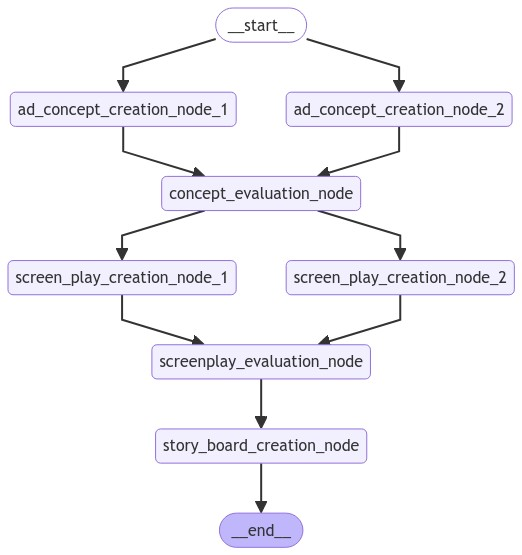

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
from simple_colors import *

graph_input = {"theme": """smart pacifier for infants"""}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for output in app.stream(graph_input, thread, stream_mode="values"):
    # print(cyan(output, ['bold']))
    pass

------ENTERING: CONCEPT CREATION NODE 1------
------ENTERING: CONCEPT CREATION NODE 2------


**CONCEPT 2:** <font color="green">### Concept: "PaciSmart - The Intelligent Pacifier for Modern Parents"

#### Overview:
"PaciSmart" is a revolutionary smart pacifier designed to provide parents with real-time insights into their infant's well-being. Equipped with advanced sensors and connectivity features, PaciSmart not only soothes your baby but also monitors vital health metrics, ensuring peace of mind for parents.

#### Features:
1. **Health Monitoring:**
   - **Temperature Sensor:** Continuously monitors the baby's body temperature and alerts parents if it goes beyond the normal range.
   - **Heart Rate Monitor:** Tracks the infant's heart rate and provides real-time data to the connected app.
   - **Breathing Pattern Analysis:** Detects irregular breathing patterns and sends immediate alerts to parents.

2. **Connectivity:**
   - **Bluetooth & Wi-Fi Enabled:** Seamlessly connects to a dedicated smartphone app, allowing parents to monitor their baby's health metrics in real-time.
   - **Cloud Storage:** Stores historical data, enabling parents and pediatricians to track the baby's health trends over time.

3. **Comfort & Safety:**
   - **Ergonomic Design:** Made from medical-grade silicone, ensuring comfort and safety for the baby.
   - **Hypoallergenic Material:** Prevents any allergic reactions, making it safe for all infants.
   - **Easy Sterilization:** Can be easily sterilized using standard methods without damaging the sensors.

4. **Smart Alerts:**
   - **Customizable Notifications:** Parents can set thresholds for different health metrics and receive alerts via the app.
   - **Sleep Monitoring:** Tracks the baby's sleep patterns and provides insights to help improve sleep quality.

5. **Interactive Features:**
   - **Soothing Sounds:** Built-in speakers that can play lullabies or white noise to help soothe the baby.
   - **LED Night Light:** A gentle night light feature that can be controlled via the app.

#### Justification:
1. **Peace of Mind for Parents:**
   - The primary concern for new parents is the health and well-being of their infant. PaciSmart provides real-time health data, reducing anxiety and allowing parents to respond promptly to any issues.

2. **Convenience:**
   - Combining a pacifier with health monitoring eliminates the need for multiple devices, making it easier for parents to keep track of their baby's health.

3. **Data-Driven Insights:**
   - The ability to store and analyze health data over time can help parents and healthcare providers make informed decisions about the baby's health and development.

4. **Safety and Comfort:**
   - The use of medical-grade, hypoallergenic materials ensures that the pacifier is safe for all infants, while the ergonomic design ensures comfort.

5. **Modern Parenting:**
   - Today's parents are tech-savvy and appreciate smart solutions that integrate seamlessly into their lifestyle. PaciSmart caters to this demographic by offering a high-tech, user-friendly product.

#### Marketing Strategy:
1. **Target Audience:**
   - New parents, especially those who are tech-savvy and health-conscious.
   - Pediatricians and healthcare providers who can recommend PaciSmart to parents.

2. **Channels:**
   - Social Media Campaigns: Highlighting real-life testimonials and the benefits of using PaciSmart.
   - Partnerships with Pediatricians: Offering trial units to pediatricians to recommend to their patients.
   - Online Parenting Communities: Engaging with forums and groups to create awareness and drive word-of-mouth marketing.

3. **Launch Event:**
   - Host a virtual launch event featuring pediatric experts discussing the importance of health monitoring for infants and demonstrating the features of PaciSmart.

4. **Promotional Offers:**
   - Early bird discounts for pre-orders.
   - Bundle offers with other baby care products.

By addressing the core concerns of modern parents and providing a comprehensive solution in the form of a smart pacifier, PaciSmart has the potential to become an essential baby care product in households worldwide.</font>

**CONCEPT 1:** <font color="blue">### Concept: "PaciSmart - The Intelligent Pacifier for Modern Parents"

#### Overview:
"PaciSmart" is a revolutionary smart pacifier designed to provide parents with real-time insights into their infant's well-being. Equipped with advanced sensors and connectivity features, PaciSmart not only soothes your baby but also monitors vital health metrics, ensuring peace of mind for parents.

#### Features:
1. **Health Monitoring:**
   - **Temperature Sensor:** Continuously monitors the baby's body temperature and alerts parents if it goes beyond the normal range.
   - **Heart Rate Monitor:** Tracks the infant's heart rate and provides real-time data to the connected app.
   - **Respiration Rate:** Measures the baby's breathing patterns to detect any irregularities.

2. **Connectivity:**
   - **Bluetooth & Wi-Fi Enabled:** Syncs with a dedicated mobile app to provide real-time updates and historical data.
   - **Cloud Storage:** Securely stores health data, allowing parents to share it with pediatricians.

3. **Comfort & Safety:**
   - **Ergonomic Design:** Made from medical-grade silicone, ensuring comfort and safety for the baby.
   - **Hypoallergenic Material:** Prevents any allergic reactions.
   - **Easy Sterilization:** Can be easily sterilized using standard methods without damaging the sensors.

4. **Smart Alerts:**
   - **Customizable Alerts:** Parents can set thresholds for temperature, heart rate, and respiration rate.
   - **Sleep Monitoring:** Alerts parents if the baby’s sleep patterns are irregular or if the baby wakes up.

5. **Additional Features:**
   - **Soothing Sounds:** Built-in speakers that can play lullabies or white noise to help soothe the baby.
   - **LED Indicator:** Visual indicators for battery life and connectivity status.

#### Justification:
1. **Peace of Mind for Parents:**
   - The primary concern for new parents is the health and well-being of their infant. PaciSmart provides real-time health data, reducing anxiety and allowing parents to respond promptly to any issues.

2. **Convenience:**
   - Combining a pacifier with health monitoring tools eliminates the need for multiple devices, making it easier for parents to keep track of their baby's health.

3. **Data-Driven Care:**
   - The ability to store and share health data with pediatricians can lead to better-informed medical consultations and personalized care for the infant.

4. **Market Demand:**
   - With the increasing adoption of smart home devices and wearables, a smart pacifier fits well into the ecosystem of connected parenting tools.

5. **Safety and Comfort:**
   - Ensuring the pacifier is made from safe, hypoallergenic materials addresses parental concerns about product safety.

### Marketing Strategy:
1. **Target Audience:**
   - New parents, tech-savvy families, and health-conscious individuals.

2. **Channels:**
   - Social media campaigns showcasing real-life testimonials.
   - Collaborations with parenting influencers and pediatricians.
   - Presence in baby product expos and tech fairs.

3. **Promotions:**
   - Introductory discounts and bundle offers with other smart baby products.
   - Subscription model for cloud storage and premium app features.

4. **Educational Content:**
   - Blog posts, webinars, and videos on the importance of monitoring infant health.
   - Guides on how to use PaciSmart effectively.

By integrating advanced technology with everyday baby care products, PaciSmart aims to revolutionize infant care, providing both comfort for the baby and peace of mind for the parents.</font>

Which concept did you like and proceed with? Is it concept 1 or 2? 1


**CONCEPT WINNER:** <font color="red">[concept_1]</font>

**CONCEPT:** <font color="red">[### Concept: "PaciSmart - The Intelligent Pacifier for Modern Parents"

#### Overview:
"PaciSmart" is a revolutionary smart pacifier designed to provide parents with real-time insights into their infant's well-being. Equipped with advanced sensors and connectivity features, PaciSmart not only soothes your baby but also monitors vital health metrics, ensuring peace of mind for parents.

#### Features:
1. **Health Monitoring:**
   - **Temperature Sensor:** Continuously monitors the baby's body temperature and alerts parents if it goes beyond the normal range.
   - **Heart Rate Monitor:** Tracks the infant's heart rate and provides real-time data to the connected app.
   - **Respiration Rate:** Measures the baby's breathing patterns to detect any irregularities.

2. **Connectivity:**
   - **Bluetooth & Wi-Fi Enabled:** Syncs with a dedicated mobile app to provide real-time updates and historical data.
   - **Cloud Storage:** Securely stores health data, allowing parents to share it with pediatricians.

3. **Comfort & Safety:**
   - **Ergonomic Design:** Made from medical-grade silicone, ensuring comfort and safety for the baby.
   - **Hypoallergenic Material:** Prevents any allergic reactions.
   - **Easy Sterilization:** Can be easily sterilized using standard methods without damaging the sensors.

4. **Smart Alerts:**
   - **Customizable Alerts:** Parents can set thresholds for temperature, heart rate, and respiration rate.
   - **Sleep Monitoring:** Alerts parents if the baby’s sleep patterns are irregular or if the baby wakes up.

5. **Additional Features:**
   - **Soothing Sounds:** Built-in speakers that can play lullabies or white noise to help soothe the baby.
   - **LED Indicator:** Visual indicators for battery life and connectivity status.

#### Justification:
1. **Peace of Mind for Parents:**
   - The primary concern for new parents is the health and well-being of their infant. PaciSmart provides real-time health data, reducing anxiety and allowing parents to respond promptly to any issues.

2. **Convenience:**
   - Combining a pacifier with health monitoring tools eliminates the need for multiple devices, making it easier for parents to keep track of their baby's health.

3. **Data-Driven Care:**
   - The ability to store and share health data with pediatricians can lead to better-informed medical consultations and personalized care for the infant.

4. **Market Demand:**
   - With the increasing adoption of smart home devices and wearables, a smart pacifier fits well into the ecosystem of connected parenting tools.

5. **Safety and Comfort:**
   - Ensuring the pacifier is made from safe, hypoallergenic materials addresses parental concerns about product safety.

### Marketing Strategy:
1. **Target Audience:**
   - New parents, tech-savvy families, and health-conscious individuals.

2. **Channels:**
   - Social media campaigns showcasing real-life testimonials.
   - Collaborations with parenting influencers and pediatricians.
   - Presence in baby product expos and tech fairs.

3. **Promotions:**
   - Introductory discounts and bundle offers with other smart baby products.
   - Subscription model for cloud storage and premium app features.

4. **Educational Content:**
   - Blog posts, webinars, and videos on the importance of monitoring infant health.
   - Guides on how to use PaciSmart effectively.

By integrating advanced technology with everyday baby care products, PaciSmart aims to revolutionize infant care, providing both comfort for the baby and peace of mind for the parents.]</font>

------ENTERING: SCRENNPLAY CREATION NODE 2------
------ENTERING: SCRENNPLAY CREATION NODE 1------


**SCREENPLAY 2:** <font color="green">### Title: "PaciSmart - The Guardian of Peace"

### Genre: Drama, Family, Tech

### Setting:
- **Primary Locations:** A modern urban home, a pediatric clinic, a tech expo.
- **Time Period:** Present day.

### Characters:
- **Ananya:** A new mother, tech-savvy, and deeply concerned about her infant's health.
- **Ravi:** Ananya's supportive husband, works in the tech industry.
- **Dr. Mehta:** A compassionate pediatrician who advocates for modern parenting tools.
- **Baby Aarav:** Ananya and Ravi's infant son, the heart of the story.
- **Tech Expo Host:** A charismatic presenter showcasing the latest in baby tech.

### Plot Overview:
Ananya and Ravi, new parents to baby Aarav, are overwhelmed with the responsibilities of ensuring their baby's health and well-being. Ananya's anxiety peaks when Aarav falls ill, leading them to discover PaciSmart, a revolutionary smart pacifier. With the help of Dr. Mehta, they learn to trust technology to monitor Aarav's health, ultimately finding peace of mind and a deeper connection with their baby.

### Scenes:

#### Opening Scene:
**Visuals:** A serene, modern nursery with soft pastel colors. Baby Aarav is sleeping peacefully in his crib.
**Sound:** Gentle lullaby playing in the background.
**Action:** Ananya gently places a traditional pacifier in Aarav's mouth and watches him sleep, her face showing a mix of love and worry.
**Camera Transition:** Slow zoom in on Ananya's face, capturing her emotions.
**Close-Up:** Ananya's hand holding the pacifier, her fingers trembling slightly.
**Text on Screen:** "PaciSmart - The Guardian of Peace"

#### Middle Scenes:

**Scene 1: Ananya's Anxiety**
**Visuals:** Ananya pacing in the living room, glancing at the baby monitor.
**Sound:** Soft ticking of a clock, distant city sounds.
**Action:** Ananya checks Aarav's temperature with a traditional thermometer, her worry increasing.
**Camera Transition:** Quick cuts between Ananya's anxious face and the baby monitor.
**Close-Up:** The thermometer showing a slightly elevated temperature.
**Dialogue:**
Ananya: (whispering) "Ravi, I'm so worried about Aarav. What if something's wrong?"

**Scene 2: Discovery of PaciSmart**
**Visuals:** Ravi browsing on his laptop, a tech expo website on the screen.
**Sound:** Soft typing sounds, background chatter from the expo video.
**Action:** Ravi excitedly calls Ananya over to show her the PaciSmart pacifier.
**Camera Transition:** Smooth pan from the laptop screen to Ananya's intrigued face.
**Close-Up:** The PaciSmart pacifier on the screen, highlighting its features.
**Dialogue:**
Ravi: "Look at this, Ananya. It's a smart pacifier that monitors health metrics. It could be exactly what we need."

**Scene 3: Visit to Dr. Mehta**
**Visuals:** A bright, welcoming pediatric clinic.
**Sound:** Soft background music, occasional baby coos.
**Action:** Dr. Mehta explains the benefits of PaciSmart to Ananya and Ravi.
**Camera Transition:** Steady shots focusing on Dr. Mehta's reassuring expressions.
**Close-Up:** Dr. Mehta holding the PaciSmart pacifier, demonstrating its features.
**Dialogue:**
Dr. Mehta: "This pacifier can monitor Aarav's temperature, heart rate, and respiration. It's a game-changer for modern parenting."

#### Climactic Scene:
**Visuals:** Aarav sleeping peacefully with the PaciSmart pacifier in his mouth, the connected app showing real-time health data.
**Sound:** Soft beeping from the app, gentle lullaby playing.
**Action:** Ananya and Ravi watch the app, their faces showing relief and happiness as they see Aarav's stable health metrics.
**Camera Transition:** Slow zoom out, capturing the family together.
**Close-Up:** The app screen showing normal health metrics, Ananya and Ravi's intertwined hands.
**Dialogue:**
Ananya: "I feel so much more at ease now. We can finally enjoy these moments with Aarav."

#### Ending Scene:
**Visuals:** A bustling tech expo, the PaciSmart booth attracting a crowd.
**Sound:** Energetic background music, excited chatter.
**Action:** The Tech Expo Host demonstrates PaciSmart to an eager audience, including Ananya and Ravi.
**Camera Transition:** Dynamic shots capturing the excitement and interest of the crowd.
**Close-Up:** Ananya and Ravi smiling, holding baby Aarav, who has the PaciSmart pacifier in his mouth.
**Text on Screen:** "PaciSmart - The Intelligent Pacifier for Modern Parents. Peace of Mind, One Suck at a Time."

### Additional Notes:
- **Color Palette:** Soft pastels for the nursery, warm tones for the family scenes, and vibrant colors for the tech expo.
- **Mood:** A mix of anxiety, relief, and joy, reflecting the emotional journey of new parents.
- **Character Consistency:** Ananya's transformation from anxious to confident, Ravi's supportive nature, and Dr. Mehta's reassuring presence.
- **Signature Elements:** Grand visuals of the tech expo, intricate storytelling of the family's journey, and the socially relevant theme of modern parenting.

By integrating advanced technology with everyday baby care products, PaciSmart aims to revolutionize infant care, providing both comfort for the baby and peace of mind for the parents.</font>

**SCREENPLAY 1:** <font color="blue">### Title: "PaciSmart: Guardian of Peace"

### Genre: Fantasy, Drama

### Setting:
- **Ancient Kingdom of Serendia**: A mystical land where technology and magic coexist.
- **Modern Urban Home**: A contemporary setting where the smart pacifier is introduced.

### Characters:
- **Queen Aria**: The wise and compassionate ruler of Serendia, who seeks a solution to protect her newborn.
- **King Rohan**: The brave and supportive husband of Queen Aria.
- **Sorcerer Elion**: A powerful sorcerer who creates the magical pacifier.
- **Modern Mother (Maya)**: A tech-savvy and caring mother in the present day.
- **Modern Father (Raj)**: Maya's supportive and innovative husband.
- **Baby Aiden**: The infant who benefits from the PaciSmart in the modern world.

### Plot Overview:
In the ancient kingdom of Serendia, Queen Aria and King Rohan are blessed with a newborn, but the baby’s health is fragile. Sorcerer Elion creates a magical pacifier that monitors the baby's well-being, ensuring peace of mind for the royal family. Fast forward to the present day, Maya and Raj discover the PaciSmart, a modern version of the ancient pacifier, which provides real-time health insights for their baby, Aiden. The story intertwines the past and present, showcasing the timeless need for parental peace of mind and the evolution of technology.

### Scenes:

#### Opening Scene:
**Visuals**: The grand palace of Serendia, with lush gardens and majestic architecture. The camera pans to the royal nursery, adorned with golden cradles and soft, glowing lights.
**Sound**: Soft, mystical music with the gentle cooing of a baby.
**Action**: Queen Aria cradles her newborn, looking worried. King Rohan enters, placing a comforting hand on her shoulder.
**Camera Transition**: A slow zoom into the baby's face, transitioning to a close-up of the pacifier.
**Close-Up**: The pacifier glows with a magical aura.
**Text on Screen**: "In a time of magic and wonder, a guardian of peace was born."

#### Middle Scenes:
**Scene 1**:
- **Visuals**: Sorcerer Elion’s mystical workshop, filled with ancient scrolls and glowing potions.
- **Sound**: The crackling of a fire and the hum of magical energy.
- **Action**: Elion crafts the magical pacifier, infusing it with protective spells.
- **Camera Transition**: A sweeping shot from Elion’s hands to the finished pacifier.
- **Close-Up**: The pacifier, now glowing with a soft blue light.
- **Dialogue**:
  - **Elion**: "This pacifier will guard your child, monitoring their health and ensuring their safety."

**Scene 2**:
- **Visuals**: A modern urban home, with sleek furniture and smart devices.
- **Sound**: The gentle hum of modern appliances.
- **Action**: Maya and Raj unbox the PaciSmart, reading the instructions with excitement.
- **Camera Transition**: A quick cut to the PaciSmart app on their phone.
- **Close-Up**: The app interface, showing real-time health data.
- **Dialogue**:
  - **Maya**: "This is incredible! We can monitor Aiden’s health in real-time."

**Scene 3**:
- **Visuals**: The royal nursery at night, with the baby sleeping peacefully.
- **Sound**: Soft lullabies playing in the background.
- **Action**: The pacifier glows, alerting Queen Aria to a change in the baby’s temperature.
- **Camera Transition**: A close-up of the pacifier, then a cut to Queen Aria’s concerned face.
- **Close-Up**: Queen Aria’s relieved expression as the pacifier stabilizes the baby’s temperature.
- **Dialogue**:
  - **Queen Aria**: "Thank you, Elion. This pacifier is truly a guardian."

#### Climactic Scene:
**Visuals**: A stormy night in the modern home, with lightning flashing outside.
**Sound**: Thunder rumbling and the baby’s cries.
**Action**: The PaciSmart alerts Maya and Raj to a sudden spike in Aiden’s heart rate.
**Camera Transition**: Rapid cuts between the app, the pacifier, and the parents rushing to the nursery.
**Close-Up**: The pacifier’s LED indicator flashing red.
**Dialogue**:
  - **Raj**: "We need to act fast. The app says his heart rate is too high."
  - **Maya**: "I’ll call the doctor. Thank goodness for PaciSmart."

#### Ending Scene:
**Visuals**: A serene morning in both the ancient kingdom and the modern home.
**Sound**: Birds chirping and soft, uplifting music.
**Action**: Queen Aria and King Rohan watch their healthy baby play, while Maya and Raj enjoy a peaceful breakfast, with Aiden happily using the PaciSmart.
**Camera Transition**: A split-screen showing both families, past and present.
**Close-Up**: The pacifier in both settings, glowing softly.
**Text on Screen**: "PaciSmart: The Intelligent Pacifier for Modern Parents. Ensuring peace of mind, then and now."

### Additional Notes:
- **Color Palette**: Warm, golden hues for the ancient kingdom; cool, modern tones for the present day.
- **Mood**: A blend of mystical wonder and contemporary comfort.
- **Character Consistency**: Strong, caring parental figures in both timelines.
- **Signature Elements**: Heroic efforts to protect the child, moral dilemmas of ensuring safety, and visually stunning sequences of magic and technology.

By blending the epic storytelling of SS Rajamouli with the innovative concept of PaciSmart, this screenplay aims to create an emotionally resonant and visually captivating advertisement that highlights the timeless need for parental peace of mind.</font>

Which screenplay did you like and proceed with? Is it 1 or 2? 1


**SCREENPLAY WINNER:** <font color="red">[screenplay_1]</font>

**SCREENPLAY:** <font color="red">[### Title: "PaciSmart: Guardian of Peace"

### Genre: Fantasy, Drama

### Setting:
- **Ancient Kingdom of Serendia**: A mystical land where technology and magic coexist.
- **Modern Urban Home**: A contemporary setting where the smart pacifier is introduced.

### Characters:
- **Queen Aria**: The wise and compassionate ruler of Serendia, who seeks a solution to protect her newborn.
- **King Rohan**: The brave and supportive husband of Queen Aria.
- **Sorcerer Elion**: A powerful sorcerer who creates the magical pacifier.
- **Modern Mother (Maya)**: A tech-savvy and caring mother in the present day.
- **Modern Father (Raj)**: Maya's supportive and innovative husband.
- **Baby Aiden**: The infant who benefits from the PaciSmart in the modern world.

### Plot Overview:
In the ancient kingdom of Serendia, Queen Aria and King Rohan are blessed with a newborn, but the baby’s health is fragile. Sorcerer Elion creates a magical pacifier that monitors the baby's well-being, ensuring peace of mind for the royal family. Fast forward to the present day, Maya and Raj discover the PaciSmart, a modern version of the ancient pacifier, which provides real-time health insights for their baby, Aiden. The story intertwines the past and present, showcasing the timeless need for parental peace of mind and the evolution of technology.

### Scenes:

#### Opening Scene:
**Visuals**: The grand palace of Serendia, with lush gardens and majestic architecture. The camera pans to the royal nursery, adorned with golden cradles and soft, glowing lights.
**Sound**: Soft, mystical music with the gentle cooing of a baby.
**Action**: Queen Aria cradles her newborn, looking worried. King Rohan enters, placing a comforting hand on her shoulder.
**Camera Transition**: A slow zoom into the baby's face, transitioning to a close-up of the pacifier.
**Close-Up**: The pacifier glows with a magical aura.
**Text on Screen**: "In a time of magic and wonder, a guardian of peace was born."

#### Middle Scenes:
**Scene 1**:
- **Visuals**: Sorcerer Elion’s mystical workshop, filled with ancient scrolls and glowing potions.
- **Sound**: The crackling of a fire and the hum of magical energy.
- **Action**: Elion crafts the magical pacifier, infusing it with protective spells.
- **Camera Transition**: A sweeping shot from Elion’s hands to the finished pacifier.
- **Close-Up**: The pacifier, now glowing with a soft blue light.
- **Dialogue**:
  - **Elion**: "This pacifier will guard your child, monitoring their health and ensuring their safety."

**Scene 2**:
- **Visuals**: A modern urban home, with sleek furniture and smart devices.
- **Sound**: The gentle hum of modern appliances.
- **Action**: Maya and Raj unbox the PaciSmart, reading the instructions with excitement.
- **Camera Transition**: A quick cut to the PaciSmart app on their phone.
- **Close-Up**: The app interface, showing real-time health data.
- **Dialogue**:
  - **Maya**: "This is incredible! We can monitor Aiden’s health in real-time."

**Scene 3**:
- **Visuals**: The royal nursery at night, with the baby sleeping peacefully.
- **Sound**: Soft lullabies playing in the background.
- **Action**: The pacifier glows, alerting Queen Aria to a change in the baby’s temperature.
- **Camera Transition**: A close-up of the pacifier, then a cut to Queen Aria’s concerned face.
- **Close-Up**: Queen Aria’s relieved expression as the pacifier stabilizes the baby’s temperature.
- **Dialogue**:
  - **Queen Aria**: "Thank you, Elion. This pacifier is truly a guardian."

#### Climactic Scene:
**Visuals**: A stormy night in the modern home, with lightning flashing outside.
**Sound**: Thunder rumbling and the baby’s cries.
**Action**: The PaciSmart alerts Maya and Raj to a sudden spike in Aiden’s heart rate.
**Camera Transition**: Rapid cuts between the app, the pacifier, and the parents rushing to the nursery.
**Close-Up**: The pacifier’s LED indicator flashing red.
**Dialogue**:
  - **Raj**: "We need to act fast. The app says his heart rate is too high."
  - **Maya**: "I’ll call the doctor. Thank goodness for PaciSmart."

#### Ending Scene:
**Visuals**: A serene morning in both the ancient kingdom and the modern home.
**Sound**: Birds chirping and soft, uplifting music.
**Action**: Queen Aria and King Rohan watch their healthy baby play, while Maya and Raj enjoy a peaceful breakfast, with Aiden happily using the PaciSmart.
**Camera Transition**: A split-screen showing both families, past and present.
**Close-Up**: The pacifier in both settings, glowing softly.
**Text on Screen**: "PaciSmart: The Intelligent Pacifier for Modern Parents. Ensuring peace of mind, then and now."

### Additional Notes:
- **Color Palette**: Warm, golden hues for the ancient kingdom; cool, modern tones for the present day.
- **Mood**: A blend of mystical wonder and contemporary comfort.
- **Character Consistency**: Strong, caring parental figures in both timelines.
- **Signature Elements**: Heroic efforts to protect the child, moral dilemmas of ensuring safety, and visually stunning sequences of magic and technology.

By blending the epic storytelling of SS Rajamouli with the innovative concept of PaciSmart, this screenplay aims to create an emotionally resonant and visually captivating advertisement that highlights the timeless need for parental peace of mind.]</font>

------ENTERING: STORY BOARD CREATION NODE------


The grand palace of Serendia, with lush gardens and majestic architecture. The camera pans to the royal nursery, adorned with golden cradles and soft, glowing lights. Queen Aria cradles her newborn, looking worried. King Rohan enters, placing a comforting hand on her shoulder. The pacifier glows with a magical aura. Text on screen: 'In a time of magic and wonder, a guardian of peace was born.'

Sorcerer Elion’s mystical workshop, filled with ancient scrolls and glowing potions. Elion crafts the magical pacifier, infusing it with protective spells. The pacifier, now glowing with a soft blue light. Text on screen: 'This pacifier will guard your child, monitoring their health and ensuring their safety.'

A modern urban home, with sleek furniture and smart devices. Maya and Raj unbox the PaciSmart, reading the instructions with excitement. The PaciSmart app on their phone, showing real-time health data. Text on screen: 'This is incredible! We can monitor Aiden’s health in real-time.'

The royal nursery at night, with the baby sleeping peacefully. The pacifier glows, alerting Queen Aria to a change in the baby’s temperature. Queen Aria’s relieved expression as the pacifier stabilizes the baby’s temperature. Text on screen: 'Thank you, Elion. This pacifier is truly a guardian.'

A stormy night in the modern home, with lightning flashing outside. The PaciSmart alerts Maya and Raj to a sudden spike in Aiden’s heart rate. Rapid cuts between the app, the pacifier, and the parents rushing to the nursery. The pacifier’s LED indicator flashing red. Text on screen: 'We need to act fast. The app says his heart rate is too high.' 'I’ll call the doctor. Thank goodness for PaciSmart.'

A serene morning in both the ancient kingdom and the modern home. Queen Aria and King Rohan watch their healthy baby play, while Maya and Raj enjoy a peaceful breakfast, with Aiden happily using the PaciSmart. A split-screen showing both families, past and present. The pacifier in both settings, glowing softly. Text on screen: 'PaciSmart: The Intelligent Pacifier for Modern Parents. Ensuring peace of mind, then and now.'

In [ ]:
from simple_colors import *

graph_input = {"theme": """Advertisement is about Fivestar chocolate and the theme is do nothing and eat five star"""}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for output in app.stream(graph_input, thread, stream_mode="values"):
    print(cyan(output, ['bold']))

{'theme': 'Advertisement is about Fivestar chocolate and the theme is do nothing and eat five star', 'overall_status': ''}
------ENTERING: CONCEPT CREATION NODE 1------
------ENTERING: CONCEPT CREATION NODE 2------


**CONCEPT 1:** <font color="blue">### Advertisement Concept: "The Art of Doing Nothing with Fivestar"

#### Concept Overview:
The advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar's rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.

#### Visual Elements:
1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.
2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "do nothing" scenarios.
3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.

#### Storyboard:
1. **Opening Scene**: A person is seen rushing through a busy day, juggling multiple tasks. The screen then fades to black with the text: "In a world that's always on the go..."
2. **Transition**: The scene transitions to a slow-motion shot of someone unwrapping a Fivestar chocolate bar. The background music shifts to a soothing, mellow tune.
3. **Main Scene**: Various people are shown in different settings, all doing nothing but enjoying their Fivestar chocolate. One person is lying in a hammock, another is lounging on a couch, and another is sitting by a lake. Each person has a look of pure bliss on their face.
4. **Close-Up Shots**: Close-up shots of the Fivestar chocolate being bitten into, showing its rich, creamy texture.
5. **Tagline**: The screen fades to black again, and the text appears: "Do Nothing. Eat Fivestar." followed by the Fivestar logo.

#### Justification:
1. **Relatability**: In today's fast-paced world, the idea of taking a moment to do nothing is highly appealing. This concept taps into the universal desire for relaxation and self-indulgence.
2. **Emotional Connection**: By associating Fivestar with moments of peace and contentment, the advertisement creates a strong emotional connection with the audience.
3. **Visual Appeal**: The serene and calming visuals will stand out and capture the viewer's attention, making the advertisement memorable.
4. **Simplicity**: The straightforward message of "Do Nothing. Eat Fivestar." is easy to understand and remember, making it effective for brand recall.

This concept leverages the universal appeal of relaxation and indulgence, positioning Fivestar as the perfect treat for those precious moments of doing nothing.</font>

**CONCEPT 2:** <font color="green">### Advertisement Concept: "The Art of Doing Nothing with Fivestar"

#### Concept Overview:
The advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar's rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.

#### Visual Elements:
1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.
2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "doing nothing" scenarios.
3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.

#### Storyboard:
1. **Opening Scene**: A close-up of a Fivestar chocolate bar being unwrapped slowly, with the sound of the wrapper crinkling.
2. **Scene 2**: Cut to a person lying in a hammock, taking a bite of the Fivestar chocolate. The camera zooms in on their face, showing a look of pure bliss.
3. **Scene 3**: Another person is seen lounging on a couch, flipping through channels on TV, but they stop and smile as they take a bite of their Fivestar.
4. **Scene 4**: A young woman is sitting by a lake, dipping her toes in the water, and savoring her Fivestar chocolate.
5. **Scene 5**: A montage of different people in various relaxing settings, all enjoying their Fivestar chocolate and doing nothing.
6. **Closing Scene**: The screen fades to black with the text "Do Nothing. Eat Fivestar." appearing, followed by the Fivestar logo and a final shot of the chocolate bar.

#### Justification:
1. **Relatability**: The concept taps into a universal desire to take a break from the hustle and bustle of daily life and simply relax. Everyone can relate to the need for downtime.
2. **Emotional Appeal**: By associating Fivestar chocolate with moments of relaxation and contentment, the advertisement creates a positive emotional connection with the audience.
3. **Visual Appeal**: The serene and cozy settings will draw viewers in and make them feel like they are part of the relaxing experience.
4. **Simplicity**: The straightforward message of "Do Nothing. Eat Fivestar." is easy to understand and remember, making it effective for brand recall.

#### Tagline:
"Do Nothing. Eat Fivestar."

This concept leverages the idea that sometimes the best thing to do is nothing at all, especially when you have a delicious Fivestar chocolate to enjoy.</font>

{'theme': 'Advertisement is about Fivestar chocolate and the theme is do nothing and eat five star', 'concept_1': '### Advertisement Concept: "The Art of Doing Nothing with Fivestar"\n\n#### Concept Overview:\nThe advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar\'s rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.\n\n#### Visual Elements:\n1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.\n2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "do nothing" scenarios.\n3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.\n\n#### Storyboard

**CONCEPT WINNER:** <font color="red">[concept_1]</font>

**CONCEPT:** <font color="red">[### Advertisement Concept: "The Art of Doing Nothing with Fivestar"

#### Concept Overview:
The advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar's rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.

#### Visual Elements:
1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.
2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "do nothing" scenarios.
3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.

#### Storyboard:
1. **Opening Scene**: A person is seen rushing through a busy day, juggling multiple tasks. The screen then fades to black with the text: "In a world that's always on the go..."
2. **Transition**: The scene transitions to a slow-motion shot of someone unwrapping a Fivestar chocolate bar. The background music shifts to a soothing, mellow tune.
3. **Main Scene**: Various people are shown in different settings, all doing nothing but enjoying their Fivestar chocolate. One person is lying in a hammock, another is lounging on a couch, and another is sitting by a lake. Each person has a look of pure bliss on their face.
4. **Close-Up Shots**: Close-up shots of the Fivestar chocolate being bitten into, showing its rich, creamy texture.
5. **Tagline**: The screen fades to black again, and the text appears: "Do Nothing. Eat Fivestar." followed by the Fivestar logo.

#### Justification:
1. **Relatability**: In today's fast-paced world, the idea of taking a moment to do nothing is highly appealing. This concept taps into the universal desire for relaxation and self-indulgence.
2. **Emotional Connection**: By associating Fivestar with moments of peace and contentment, the advertisement creates a strong emotional connection with the audience.
3. **Visual Appeal**: The serene and calming visuals will stand out and capture the viewer's attention, making the advertisement memorable.
4. **Simplicity**: The straightforward message of "Do Nothing. Eat Fivestar." is easy to understand and remember, making it effective for brand recall.

This concept leverages the universal appeal of relaxation and indulgence, positioning Fivestar as the perfect treat for those precious moments of doing nothing.]</font>

{'theme': 'Advertisement is about Fivestar chocolate and the theme is do nothing and eat five star', 'concept_1': '### Advertisement Concept: "The Art of Doing Nothing with Fivestar"\n\n#### Concept Overview:\nThe advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar\'s rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.\n\n#### Visual Elements:\n1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.\n2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "do nothing" scenarios.\n3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.\n\n#### Storyboard

**SCREENPLAY 2:** <font color="green">### Screenplay for 30-Second Advertisement: "The Art of Doing Nothing with Fivestar"

#### Scene 1: Opening Scene (0-5 seconds)
- **Visual**: A bustling city street. People are rushing, cars honking, and a person (let's call him Alex) is seen juggling multiple tasks—talking on the phone, carrying a briefcase, and trying to hail a cab.
- **Audio**: The sound of city noise, hurried footsteps, and a phone ringing.
- **Text on Screen**: "In a world that's always on the go..."

#### Scene 2: Transition (5-10 seconds)
- **Visual**: The screen fades to black. The noise fades out, replaced by a soothing, mellow tune. The scene transitions to a slow-motion shot of Alex unwrapping a Fivestar chocolate bar.
- **Audio**: Soft, calming music begins to play.
- **Text on Screen**: "Take a moment..."

#### Scene 3: Main Scene (10-25 seconds)
- **Visual**: 
  - **Shot 1**: Alex is now lying in a hammock in a lush garden, gently swaying with a look of pure bliss on his face as he takes a bite of the Fivestar chocolate.
  - **Shot 2**: A woman (let's call her Priya) is lounging on a comfy couch in a sunlit living room, eyes closed, savoring the taste of Fivestar.
  - **Shot 3**: An elderly man (let's call him Mr. Singh) is sitting by a peaceful lakeside, dipping his feet in the water, and enjoying his Fivestar chocolate.
- **Audio**: The soothing music continues, with occasional sounds of nature like birds chirping and water gently lapping.
- **Visual Details**: Each character has a look of pure contentment and relaxation, emphasizing the theme of doing nothing.

#### Scene 4: Close-Up Shots (25-28 seconds)
- **Visual**: Close-up shots of the Fivestar chocolate being bitten into, showing its rich, creamy texture. The camera captures the smooth chocolate and caramel layers.
- **Audio**: The sound of the chocolate being bitten into, enhancing the sensory experience.

#### Scene 5: Tagline and Logo (28-30 seconds)
- **Visual**: The screen fades to black again. The text appears: "Do Nothing. Eat Fivestar." followed by the Fivestar logo.
- **Audio**: The soothing music fades out, leaving a moment of silence for impact.

#### Justification:
1. **Relatability**: The opening scene captures the hectic pace of modern life, making the transition to relaxation with Fivestar highly relatable.
2. **Emotional Connection**: The serene and content expressions of the characters create a strong emotional connection, associating Fivestar with moments of peace and indulgence.
3. **Visual Appeal**: The calming visuals and close-up shots of the chocolate enhance the sensory appeal, making the advertisement memorable.
4. **Simplicity**: The straightforward message of "Do Nothing. Eat Fivestar." is easy to understand and remember, ensuring effective brand recall.

This screenplay leverages the universal appeal of relaxation and indulgence, positioning Fivestar as the perfect treat for those precious moments of doing nothing.</font>

**SCREENPLAY 1:** <font color="blue">### Advertisement Concept: "The Art of Doing Nothing with Fivestar"

#### Concept Overview:
The advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar's rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.

#### Visual Elements:
1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.
2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "do nothing" scenarios.
3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.

#### Storyboard:
1. **Opening Scene**: A person is seen rushing through a busy day, juggling multiple tasks. The screen then fades to black with the text: "In a world that's always on the go..."
2. **Transition**: The scene transitions to a slow-motion shot of someone unwrapping a Fivestar chocolate bar. The background music shifts to a soothing, mellow tune.
3. **Main Scene**: Various people are shown in different settings, all doing nothing but enjoying their Fivestar chocolate. One person is lying in a hammock, another is lounging on a couch, and another is sitting by a lake. Each person has a look of pure bliss on their face.
4. **Close-Up Shots**: Close-up shots of the Fivestar chocolate being bitten into, showing its rich, creamy texture.
5. **Tagline**: The screen fades to black again, and the text appears: "Do Nothing. Eat Fivestar." followed by the Fivestar logo.

#### Justification:
1. **Relatability**: In today's fast-paced world, the idea of taking a moment to do nothing is highly appealing. This concept taps into the universal desire for relaxation and self-indulgence.
2. **Emotional Connection**: By associating Fivestar with moments of peace and contentment, the advertisement creates a strong emotional connection with the audience.
3. **Visual Appeal**: The serene and calming visuals will stand out and capture the viewer's attention, making the advertisement memorable.
4. **Simplicity**: The straightforward message of "Do Nothing. Eat Fivestar." is easy to understand and remember, making it effective for brand recall.

This concept leverages the universal appeal of relaxation and indulgence, positioning Fivestar as the perfect treat for those precious moments of doing nothing.

### Detailed Screenplay

#### Opening Scene
**[INT. OFFICE - DAY]**

*The camera follows a young woman, ANITA, in her late 20s, as she rushes through a busy office. Papers are flying, phones are ringing, and she’s juggling multiple tasks. The camera zooms in on her stressed face.*

**TEXT ON SCREEN: "In a world that's always on the go..."**

*The screen fades to black.*

#### Transition
**[EXT. GARDEN - DAY]**

*The scene transitions to a slow-motion shot of a hand unwrapping a Fivestar chocolate bar. The background music shifts to a soothing, mellow tune. The camera captures the rich, creamy texture of the chocolate as it is unwrapped.*

#### Main Scene
**[EXT. GARDEN - DAY]**

*The camera pans to a serene garden where a man, RAJ, in his 30s, is lying in a hammock. He takes a bite of the Fivestar chocolate and closes his eyes in bliss.*

**[INT. LIVING ROOM - DAY]**

*The scene shifts to a sunlit living room where an elderly woman, MRS. SHARMA, is lounging on a comfy couch. She takes a bite of her Fivestar chocolate and smiles contentedly.*

**[EXT. LAKESIDE - DAY]**

*The camera moves to a peaceful lakeside spot where a teenager, PRIYA, is sitting by the water. She takes a bite of her Fivestar chocolate and looks out at the lake with a look of pure satisfaction.*

#### Close-Up Shots
**[EXT. VARIOUS LOCATIONS - DAY]**

*Close-up shots of the Fivestar chocolate being bitten into by each character, showing its rich, creamy texture. The camera captures the chocolate melting and the characters' expressions of delight.*

#### Tagline
*The screen fades to black.*

**TEXT ON SCREEN: "Do Nothing. Eat Fivestar."**

*The Fivestar logo appears on the screen.*

#### End Scene
*The advertisement ends with a final shot of the Fivestar chocolate bar, unwrapped and ready to be enjoyed.*

---

This screenplay captures the essence of SS Rajamouli's style with its focus on visual storytelling, emotional connection, and a strong, memorable message. The serene and calming visuals, combined with the universal appeal of relaxation and indulgence, make this advertisement both relatable and impactful.</font>

{'theme': 'Advertisement is about Fivestar chocolate and the theme is do nothing and eat five star', 'concept_1': '### Advertisement Concept: "The Art of Doing Nothing with Fivestar"\n\n#### Concept Overview:\nThe advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar\'s rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.\n\n#### Visual Elements:\n1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.\n2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "do nothing" scenarios.\n3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.\n\n#### Storyboard

**SCREENPLAY WINNER:** <font color="red">[screenplay_1]</font>

**SCREENPLAY:** <font color="red">[### Advertisement Concept: "The Art of Doing Nothing with Fivestar"

#### Concept Overview:
The advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar's rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.

#### Visual Elements:
1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.
2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "do nothing" scenarios.
3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.

#### Storyboard:
1. **Opening Scene**: A person is seen rushing through a busy day, juggling multiple tasks. The screen then fades to black with the text: "In a world that's always on the go..."
2. **Transition**: The scene transitions to a slow-motion shot of someone unwrapping a Fivestar chocolate bar. The background music shifts to a soothing, mellow tune.
3. **Main Scene**: Various people are shown in different settings, all doing nothing but enjoying their Fivestar chocolate. One person is lying in a hammock, another is lounging on a couch, and another is sitting by a lake. Each person has a look of pure bliss on their face.
4. **Close-Up Shots**: Close-up shots of the Fivestar chocolate being bitten into, showing its rich, creamy texture.
5. **Tagline**: The screen fades to black again, and the text appears: "Do Nothing. Eat Fivestar." followed by the Fivestar logo.

#### Justification:
1. **Relatability**: In today's fast-paced world, the idea of taking a moment to do nothing is highly appealing. This concept taps into the universal desire for relaxation and self-indulgence.
2. **Emotional Connection**: By associating Fivestar with moments of peace and contentment, the advertisement creates a strong emotional connection with the audience.
3. **Visual Appeal**: The serene and calming visuals will stand out and capture the viewer's attention, making the advertisement memorable.
4. **Simplicity**: The straightforward message of "Do Nothing. Eat Fivestar." is easy to understand and remember, making it effective for brand recall.

This concept leverages the universal appeal of relaxation and indulgence, positioning Fivestar as the perfect treat for those precious moments of doing nothing.

### Detailed Screenplay

#### Opening Scene
**[INT. OFFICE - DAY]**

*The camera follows a young woman, ANITA, in her late 20s, as she rushes through a busy office. Papers are flying, phones are ringing, and she’s juggling multiple tasks. The camera zooms in on her stressed face.*

**TEXT ON SCREEN: "In a world that's always on the go..."**

*The screen fades to black.*

#### Transition
**[EXT. GARDEN - DAY]**

*The scene transitions to a slow-motion shot of a hand unwrapping a Fivestar chocolate bar. The background music shifts to a soothing, mellow tune. The camera captures the rich, creamy texture of the chocolate as it is unwrapped.*

#### Main Scene
**[EXT. GARDEN - DAY]**

*The camera pans to a serene garden where a man, RAJ, in his 30s, is lying in a hammock. He takes a bite of the Fivestar chocolate and closes his eyes in bliss.*

**[INT. LIVING ROOM - DAY]**

*The scene shifts to a sunlit living room where an elderly woman, MRS. SHARMA, is lounging on a comfy couch. She takes a bite of her Fivestar chocolate and smiles contentedly.*

**[EXT. LAKESIDE - DAY]**

*The camera moves to a peaceful lakeside spot where a teenager, PRIYA, is sitting by the water. She takes a bite of her Fivestar chocolate and looks out at the lake with a look of pure satisfaction.*

#### Close-Up Shots
**[EXT. VARIOUS LOCATIONS - DAY]**

*Close-up shots of the Fivestar chocolate being bitten into by each character, showing its rich, creamy texture. The camera captures the chocolate melting and the characters' expressions of delight.*

#### Tagline
*The screen fades to black.*

**TEXT ON SCREEN: "Do Nothing. Eat Fivestar."**

*The Fivestar logo appears on the screen.*

#### End Scene
*The advertisement ends with a final shot of the Fivestar chocolate bar, unwrapped and ready to be enjoyed.*

---

This screenplay captures the essence of SS Rajamouli's style with its focus on visual storytelling, emotional connection, and a strong, memorable message. The serene and calming visuals, combined with the universal appeal of relaxation and indulgence, make this advertisement both relatable and impactful.]</font>

{'theme': 'Advertisement is about Fivestar chocolate and the theme is do nothing and eat five star', 'concept_1': '### Advertisement Concept: "The Art of Doing Nothing with Fivestar"\n\n#### Concept Overview:\nThe advertisement will revolve around the idea that indulging in a Fivestar chocolate bar is the ultimate way to embrace the art of doing nothing. The campaign will highlight how Fivestar\'s rich, creamy texture and delicious taste make it the perfect companion for those moments when you just want to relax and do absolutely nothing.\n\n#### Visual Elements:\n1. **Setting**: A cozy, serene environment such as a hammock in a lush garden, a comfy couch in a sunlit living room, or a peaceful lakeside spot.\n2. **Characters**: A diverse group of people (different ages, genders, and ethnicities) all enjoying their Fivestar chocolate in various "do nothing" scenarios.\n3. **Mood**: Calm, relaxed, and content. The visuals should evoke a sense of peace and satisfaction.\n\n#### Storyboard

BadRequestError: Error code: 400 - {'error': {'code': 'content_policy_violation', 'inner_error': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'profanity': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}, 'revised_prompt': "A film scene transitioning into darkness. Words appearing on the pitch-black screen, stating: 'Do Nothing. Eat Fivestar.' Subsequently, the recognizable logo of Fivestar materializes in the midst of the screen."}, 'message': 'Your request was rejected as a result of our safety system. The revised prompt may contain text that is not allowed by our safety system.', 'type': 'invalid_request_error'}}